# <div align="center"> Learning to play Blackjack with Q-learning </div>

### <font color="red"> To do: CATER FOR DRAWS IN SUCCESS_RATE, e.g. remove them mean = sum() - {count()-sum(x==0)}. Then retrain</font>

In this notebook I will show how Q-learning can be used by an agent with no prior knowledge to teach itself to play Blackjack. While I would not expect the agent to find a way to make money from gambling, I am interested in whether artifical intelligence can play Blackjack better than a human after experiencing hundreds of thousands of games. To make the comparison we will simulate games under a strategy recommended by a human expert, and hopefully show that the agent can consistently beat human performance.

In terms of coding strategy, I start with low level functions that are incorporated into increasingly large functions. This helps us reduce duplication of code when we vary the parameters under which agents are trained.


#### Special thanks:
My implementation relies heavily on the following key sources, which I highly recommend:
 - <a href="https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py" target="_blank" >Blackjack environment created by OpenAI Gym</a>
 - <a href="https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0" target="_blank" >Arthur Juliani's Medium tutorial on Q-learning implementation</a>
 -  <a href="https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-7-action-selection-strategies-for-exploration-d3a97b7cceaf" target="_blank" >Arthur Juliani's Medium tutorial on policy rule implementation</a>


#### Contents:
1. Create Blackjack environment 
2. Q-learning implementation and variations
3. Connect Q-learning algorithm with environment
4. Training example
5. Optimization: training with grid search
6. Comparison against human strategy
7. Discussion

### 0) Load modules & basic set-up

In [1]:
import gym
from gym import spaces
from gym.utils import seeding

import pandas as pd
import numpy as np
import random
import datetime
import pickle
import os

from sklearn.model_selection import ParameterGrid

import matplotlib.pyplot as plt
import seaborn as sns

# hide warnings
import warnings
warnings.filterwarnings('ignore')

### 1) Create Blackjack environment

The basics of the environment are handled in local files *blackjack_env.py* and *settings.py*. The former file is the main environment as coded by <a href="https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py" target="_blank" >OpenAI Gym</a>, plus some minor modifications I added to make the game more interesting such as the inclusion of the "Double" action. The latter file contains some parameters I added which influence the laws of the game held in the main environment file, e.g. controlling when the dealer stops taking cards or how many different actions we allow our agent to perform.

For those unfamiliar with Blackjack, I will include the description of the game written by OpenAI Gym. I should emphasise that this is a slightly different version to the standard game, since the action "split" is removed to keep things a little simpler.

<div class="alert alert-info">
<h4> Blackjack rules: </h4>
<p>
“Blackjack is a card game where the goal is to obtain cards that sum to as near as possible to 21 without going over.  They're playing against a fixed dealer. Face cards (Jack, Queen, King) have point value 10. Aces can either count as 11 or 1, and it's called 'usable' at 11. This game is placed with an infinite deck (or with replacement).
The game starts with each (player and dealer) having one face up and one face down card. The player can request additional cards (hit=1) until they decide to stop (stick=0) or exceed 21 (bust). After the player sticks, the dealer reveals their facedown card, and draws until their sum is 17 or greater.  If the dealer goes bust the player wins. If neither player nor dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21.  The reward for winning is +1, drawing is 0, and losing is -1.” – <i>OpenAI Gym source code</i> </p>
<p>
    
<b>NB:</b> The above variant of Blackjack excludes the actions ‘Double’ and ‘Split’, though we reinstate 'Double' to study agents’ approach to risk-taking. We leave out the latter for simplicity reasons.
</p>
</div>


In [2]:
# load settings of environment from local file
from settings import *

# load the Blackjack environment from local file
from blackjack_env import *

# create environment
env = BlackjackEnv()

# Confirm the environment our agent will play in
ENV_VALS = (BLACKJACK_SCORE, DEALER_STOP, DOUBLE_BIAS, ODDS_BOOST, NUM_ACTIONS)
print("Created environment:")
print("Goal: %i | DealerStop: %i | DoubleBias: %i | DoubleBoost: %i | NumActions: %i" % ENV_VALS)

Created environment:
Goal: 21 | DealerStop: 4 | DoubleBias: 0 | DoubleBoost: 2 | NumActions: 3


It is always useful to articulate the environment's state transition matrix before training. This helps us understand the environment our agent needs to traverse in a more mathematical fashion, particularly the probabilities associated with drawing cards randomly. But to keep this notebook focussed on Q-learning itself, I have included that analysis in a <a href="https://github.com/slmwest/blackjack/blob/master/state_transition_analysis.ipynb" target="_blank">separate notebook here</a>.

### 2) Q-learning implementation and variations

We will start by implementing a series of selection policies, all of which control how our agent chooses actions. Since the agent will start with a blank canvas, we cannot simply let the agent always pick the "best" action. Rather, these policies help the agent manage the "exploration-exploitation trade-off". In all cases, the agent will start by prioritising "exploration": choosing actions mostly randomly so that it can experience as many different rewards and penalties as possible. As it gains more experience, it will begin to reduce the frequency of these random actions, instead prioritising "exploitation": using its experience so far to choose the action with highest expected future rewards.

The policies implemented are:
- e-greedy policy
- boltzmann policy
- both of the above but with Double-Q learning (see more in the following block of code)

In [26]:
def select_egreedy(Q_row, number_actions, eps=0.9):
    """
    Select an action (index) based on e-greedy policy,
    e.g. random with probability e and per
    current Q-values with probability 1-e
    """
    if np.random.rand() < eps:
        # pick by random choice
        return np.random.choice(np.arange(0, number_actions))   
    else:
        # choose highest expected value action
        return np.argmax(Q_row)    

def select_boltzmann(Q_row, number_actions, tau=1):
    """
    Select an action (index) based on current Q values and
    the current state of annealing, e.g. using inverse
    temperature, tau.
    
    PARAMS:
    tau = inverse temperature, e.g. as tau approaches 0
          boltzmann distribution approaches uniform sampling.
          higher tau prefers actions with higher expected values
    """
    # normalize wrt minimum values, ensuring no negatives
    Q_row_ajd = Q_row - Q_row.min()

    # calculate probabilities under boltzmann distribution
    Q_pr = np.exp(tau * Q_row_ajd) / np.exp(tau * Q_row_ajd).sum()
    
    # Make selection based on probabilities
    try:
        action_value = np.random.choice(Q_pr, p=Q_pr)
    except:
        # we might exceed memory limits for very large numbers
        # when the temperature is very low. In these cases
        # we would do well to simply pick the max value again
        action_value = np.argmax(Q_row)
    return np.argmax(Q_pr == action_value)

def select_a(Q_row, policy="e", param=0.9):
    """ Select action from a row of Q for the given state
    and for a given policy & parameter
    
    if policy == "e" then we will use e-greedy policy
    if policy == "b" then we will use boltzmann distribution
    """
    # choose action based on policy required
    if policy=="e":
        # use e-greedy policy, where param = epsilon
        return select_egreedy(Q_row, env.action_space.n, param)
    else:
        # use boltzmann policy, where param = tau = inverse temperature
        return select_boltzmann(Q_row, env.action_space.n, param)
    
def doubleQ_select(Q_a, Q_b, s, policy="e", policy_param = 0.9):
    """
    Function which enables selection using two Q matrices. Per van Hasselt's
    original implementation:
       'In our experiments, we calculated the average of the two Q values for each
    action and then performed e-greedy exploration with the resulting average
    Q values.' (Hado van Hasselt)
    
    Optional params:
        policy = "e" or "b" for e-greedy and boltzmann respectively
        policy_param = float, epsilon if e-greedy or inverse temperature (tau)
                       if boltzmann 
    """
    
    # take average Q values under consideration for given state
    Q_avg_row =  (Q_a[s] + Q_b[s])/2
    
    # choose action based on given policy and policy parameter
    return select_a(Q_avg_row, policy, policy_param)

We now move to defining our update rules, which is how the agent learns from experience in playing Blackjack. We will use the standard update rule as well as a variation called **Double Q learning**, where two matrixes are maintained to avoid over-estimation of expected returns. For more information on this variation see https://arxiv.org/abs/1509.06461 

In [4]:
def vanillaQ_update(Q, r, s, s1, a, lr, y):
    """
    Update Q-matrix using standard update rule
    """
    Q[s][a] = Q[s][a] + lr*(r + y*np.max(Q[s1]) - Q[s][a])
    return Q

def doubleQ_update(Q_a, Q_b, r, s0, s1, a,
                   lr, y, prob_update_Q_a = 0.5):
    """
    Randomly select a Q matrix to update, estimating future
    rewards from the other matrix. Per van Hasselt's original
    implementation.
    
    Parameters:
        - prob_update_Q_a: probability of updating the first matrix.
                           (allows experimentation with reliance on
                           the first Q matrix vs the second Q matrix)
    """
    
    if np.random.rand() < prob_update_Q_a:
        # update Q_a matrix, taking copy before update for reference
        Q_old = np.copy(Q_a)
        optimal_a = np.argmax(Q_a[s1][a])
        Q_a[s0][a] = Q_a[s0][a] + lr*(r + y*Q_b[s1][optimal_a] - Q_a[s0][a])
        
    else:
        # update Q_b matrix, taking copy before update for reference
        Q_old = np.copy(Q_b)
        optimal_b = np.argmax(Q_b[s1][a])
        Q_b[s0][a] = Q_b[s0][a] + lr*(r + y*Q_a[s1][optimal_b] - Q_b[s0][a])
        
    return Q_a, Q_b, Q_old

### 3) Connect Q-learning algorithm with environment

Now that we have an environment and functions that implement Q-learning, we can connect them together and watch our agent learn to play! We will put this functionality into a function so that we can easily recall it under different parameters in the rest of this notebook. 

In [93]:
def playGame(Q_a=None, Q_b = None, verbose=0,
             dbl_Q=0, lr=0.1, y=0.6,
             policy = "e", policy_param=0.7,
             num_episodes = 1, cb_over_num_eps=10000):
    """
    Main function where agent learns to play Blackjack.
    
    Inputs:
      Q_a, Q_b        = None, None or pre-trained matrix, None
      verbose         = verbosity level
      dbl_Q           = 1 if using double Q learning
      policy          = "e" for e-greedy, "b" for boltzmann
      policy_param    = float controlling above policy
      num_episodes    = number of games to play
      cb_over_num_eps = maintain a callback version of agent 
                        if they have superior performance over
                        this number of games
                        
    Outputs:
      Q_out           = Q-matrix of agent after final episode
      rList           = list of agent's rewards in each episode 
      Q_cb            = Q-matrix of callback agent
      last_cb_ep      = episode number where callback agent was created
    """
    
    # state space needs to be blackjack_score+11
    # e.g. ace on top of a score of 21
    if Q_a is None:
        Q_a = np.zeros([BLACKJACK_SCORE+11,11,2,env.action_space.n])

    # take a copy of Q matrix if we are using double Q learning
    if dbl_Q != 0:
        Q_b = np.copy(Q_a)
    
    # prepare a 'call-back' version of the Q-matrix
    # e.g. the one with best mean rewards over last N episodes
    Q_cb = Q_a.copy()
    best_meanR = -999999    # value holding "best score" yet
    last_cb_ep = 0          # record of last episode the call-back is made to
    a_freq = np.zeros(env.action_space.n)

    # if using Boltzmann policy, set rate of annealing (tau = inverse temperature)
    if policy=="b":
        tau_growth = (200/policy_param)**(1/num_episodes)

    #create lists to contain total rewards and steps per episode
    rList = []
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        
        # game will not exceed 20 moves, limit while loop out of caution
        while j < 20:
            j+=1

            # choose an acion per given policy        
            if dbl_Q==0:
                Q_row = Q_a[s]
                a = select_a(Q_row, policy, policy_param)  
            else:
                Q_avg_row =  (Q_a[s] + Q_b[s])/2
                a = select_a(Q_avg_row, policy, policy_param) 

            #Get new state and reward from environment
            Q_old = np.copy(Q_a)
            player_hand_old = env.player.copy()
            s1,r,d,_ = env.step(a)
            
            # Update Q-Table with new knowledge, unless in testing mode (lrate = 0.0)
            if lr > 0:
                if dbl_Q==0:
                    Q_a[s][a] = Q_a[s][a] + lr*(r + y*np.max(Q_a[s1]) - Q_a[s][a])
                else:
                    # Double-Q learning: use the second matrix as estimate of expected returns
                    Q_a, Q_b, Q_old = doubleQ_update(Q_a, Q_b, r, s, s1, a, lr, y)
    
            # inspect the step & Q matrix once, at 1/5 through training
            if (i == num_episodes//5) & (verbose > 2):
                if ((dbl_Q==0)|(np.array_equal(Q_b, Q_old))):
                    Q_new = np.copy(Q_a)
                else:
                    Q_new = np.copy(Q_b) 
                show_step(player_hand_old, env.player, env.dealer,
                          s, s1, a, Q_old, Q_new, r, d)
            
            # update rewards and state
            rAll += r
            s = s1

            if d == True:            
                #Reduce chance of random action as we train the model.
                # for e-greedy policy, reduce epsilon
                if policy=="e":
                    if policy_param >= 0.5:
                        policy_param *= 0.99999
                    else:
                        policy_param *= 0.9999
                        
                # for boltzmann policy, increase tau (inverse temperature)
                if policy=="b":
                    policy_param *= tau_growth
                
                # For each of the final 5 episodes, show the game for inspection
                if (i >= (num_episodes-5)) & (verbose > 1):
                    show_ep(env.player, env.dealer, r, i)
                
                break

        # append reward to list
        rList.append(rAll)
        
        # update the callback Q-matrix IIF better average over last N episodes
        meanR_lastN_eps = meanR_lastN(rList, n=cb_over_num_eps)
        if ((i > cb_over_num_eps) & (meanR_lastN_eps > best_meanR)):
            
            # take average of Q-values first if double Q learning
            if dbl_Q == 0:
                Q_cb = np.copy(Q_a)
            else:
                Q_cb = (Q_a + Q_b) / 2
            last_cb_ep = i
            best_meanR = meanR_lastN_eps
            
        # show some training feedback every n episodes
        feedback_freq = 25000
        if verbose > 0:
            if i % feedback_freq == 0:
                print("Ep: {}\tMean reward over last {} episodes: {}. ({}-policy @ {})".format(i,
                        cb_over_num_eps, meanR_lastN_eps,
                        policy, np.around(policy_param, decimals=5)))
        
    # show overall success history of agent 
    if verbose > 1:
        plt.figure(figsize=(12,4))
        plt.plot(np.cumsum(rList))
        plt.title('Performance vs. episodes')
        plt.ylabel('Total Returns')
        plt.xlabel('Episode number')
        plt.axvline(x=last_cb_ep, linestyle="--", color="black")    # show the last callback episode
        plt.show()
        
    # before returning Q matrix, take average if double Q-learning
    if dbl_Q == 0:
        Q_out = np.copy(Q_a)
    else:
        Q_out = (Q_a + Q_b)/2
        
    return Q_out, rList, Q_cb, last_cb_ep

### 4) Training example

Before we start training, we want to have some functions that let us evaluate the agent's performance numerically, as well as some ability to visually inspect what is going on at both a high- and granular-level.

In [124]:
def mode(l):
    """ Find the mode of a given list l. """
    return max(set(l), key=l.count)

def meanR_lastN(r_list, n=200):
    """ Find mean over the last n items in a list """
    return np.mean(r_list[-n:])

def calc_success_rate(rList, eval_last_n=50000, produce_ts=False, title_add=" (final agent)"):
    """ Calcuate success rate over moving window using a given rList
        (This is more easy to understand in context of Blackjack)"""
    # convert to binary 1/0 for success/failure
    r_01 = [1*(r>0) for r in rList]
    ts_success = []
    
    # calculate average success rate for evaluation period
    mean_success_rate = np.mean(r_01[-eval_last_n:])
    
    if produce_ts:
        # calculate success rate over moving window
        window=eval_last_n #//200
        ts_step=1#ts_step = np.max([window//10, 1]) # must be positive step 
        for i in np.arange(window, len(rList), ts_step):
            success_in_window = np.mean(r_01[i-window:i])
            ts_success.append(success_in_window)
            
        # plot success over time, plus mean success rate in eval period
        plt.figure()
        plt.suptitle("Success rate over time{}".format(title_add))
        plt.title("Mean success rate during evaluation: %.3f" % mean_success_rate)
        plt.plot(ts_success)
        plt.ylim([0.0,1.0])
        plt.ylabel("Success rate")
        plt.xlabel("Number of episodes after initial evaluation @ Ep. {}".format(window))
        plt.show()

    return ts_success, mean_success_rate
    

def action_dict(a, short=False):
    if short:
        lookup = {0: "St", 1: "Hi", 2: "Db", 3: "Su", 4: "In"}
    else:
        lookup = {0: "Stick", 1: "Hit", 2: "Double", 3: "Surrender", 4: "Invest"}
    return lookup[a]

def convert_first_1_to_11(l):
    """ Convert the first 1 in a hand to 11, e.g. to faciliate understanding of hands played involving an Ace """
    for idx, i in enumerate(l):
        if i == 1:
            l[idx] = 11
            break
    return l

In [91]:
def show_ep(player_hand, dealer_hand, reward, ep_no, cumulative=True):
    """ Summarise the episode in text once it is complete """
    
    # set some placeholder strings to indicate who won/lost/drew
    pl_bust = ""
    dl_bust = ""
    
    # show if anyone went bust with XXX
    if is_bust(player_hand):
        pl_bust = "XXX"
    if is_bust(dealer_hand):
        dl_bust = "XXX"
    
    # show who won, using !!! for win and --- for draw
    if reward > 0:
        pl_win = "!!!"
        dl_win = ""
    elif reward < 0:
        pl_win = ""
        dl_win = "!!!"
    else:
        pl_win = "---"
        dl_win = "---"
        
    # update hands to show effects of an Ace being used as 11 (instead of 1)
    if usable_ace(player_hand):
        player_hand = convert_first_1_to_11(player_hand)
    if usable_ace(dealer_hand):
        dealer_hand = convert_first_1_to_11(dealer_hand)
        
    # display results
    print("--- SUMMARY OF EP #{} ---".format(ep_no))
    if cumulative:
        # simplest view
        print("Player:\t{} {}{}".format(np.cumsum(player_hand), pl_bust, pl_win))
        print("Dealer:\t{} {}{}".format(np.cumsum(dealer_hand), dl_bust, dl_win))
        print(player_hand)
        print(dealer_hand)
    else:
        # more detailed view, showing progression of cards from initial (visible) hands to final hands
        print("Player:\t{} >> {} >> {} {}{}".format(player_hand[:2], player_hand, sum_hand(player_hand),
                                                    pl_bust, pl_win))
        print("Dealer:\t{} >> {} >> {} {}{}".format(dealer_hand[:1], dealer_hand, sum_hand(dealer_hand),
                                                    dl_bust, dl_win))

def show_step(player_hand_old, player_hand_new, dealer_hand,
              s0, s1, a, Q0, Q1, r, d):
    """ Give a detailed view of each step in a hand """
    # current state summary and action
    print("""-----------------------
Player's old hand:\t{} (={})
Dealer's face-up card:\t{}
Player had useable:\t{}
Player action:\t\t{} ({})""".format(player_hand_old, s0[0], s0[1], s0[2], a, action_dict(a)))
    
    # effects of action
    if player_hand_old != player_hand_new:
        print("""Player got card:\t{}""".format(player_hand_new[-1]))
        
    # Dealer's eventual outcome
    print("Dealer's hand:\t{} (={})".format(dealer_hand, sum_hand(dealer_hand)))
    print("{}\n{}".format(s0, s1))
    
    print("r:{} | Done: {}".format(r, d))
    
    # show two Q matrices separately
    inspect_Q(Q0)
    inspect_Q(Q1)
    
    # show the difference
    Q_diff = Q1 - Q0
    inspect_Q(Q_diff)

def inspect_Q(Q_in):
    """ Inspect the Q matrix as heatmaps
    Split out each action's Q-values for all possible states"""
        
    # Heatmaps: Show side-by-side action Q-matrix, with two rows for each Usable Ace state
    color_limits = np.max([abs(np.min(Q_in)), np.max(Q_in)])
    i_labels = ['No useable ace', 'Useable ace']
    j_labels = ['Stick', 'Hit', 'Double', 'Surrender', 'Invest'][:NUM_ACTIONS]
    
    # new row of plots for each of the binary states Ace / no Ace
    for i in np.arange(0, len(i_labels)):    
        plt.figure()
        f, axes = plt.subplots(1,len(j_labels), sharex=False, sharey=False,
                                          figsize=(12,6))
        plt.title(i_labels[i])
        # show Q values for each possible action, across all hand values x initial dealer card
        for j in np.arange(0, len(j_labels)):
            # show each heat map, adding color bar for the last plot only
            showCbar = j == len(j_labels)-1
            # obtain the relevant Q values - hiding non-used states (4- & 22+ for player / 0 for dealer)
            g = sns.heatmap(Q_in[4:22,1:,i,j], cmap='seismic_r', cbar=showCbar,
                            vmin = -color_limits, vmax = color_limits, center=0, ax=axes[j])
            g.set_title("{}\n - {} - ".format(j_labels[j], i_labels[i]))
            g.set_xlabel('Dealer initial card')
            # set agent hand value range of 4-21 inclusive, dealer 2-11 inclusive
            g.set_yticklabels(np.arange(4,22), rotation=0)
            g.set_xticklabels(np.arange(1,11), rotation=0)  # where Ace = 1 for now
            # only show y label on first plot
            if j == 0:
                g.set_ylabel('Agent hand value')
                
        plt.show()

We are almost ready to start training. All we have to do first is choose how long we want to train the agent for, how many games we are going to evaluate it over, and of course some hyper-parameter values. We will start with some parameter values which seem sensible, and move onto more robust experimentation in the following section. For this reason we will keep the number of training episodes and evaluation window fairly low for now.

In [113]:
### Set scope of training and evaluation
# number of episodes to train agent over
NUM_EPISODES_TRAIN = 10000           

# evaluate agent with mean rewards over last (N) episodes
EVAL_LAST_N_EPS = 1000                 

### Set verbosity level
# 0: nothing
# 1: validation metrics only
# 2: validation, perf-vs-episodes, last 5 games
# 3: inspect Q-matrix update 1/5 of way into training
VERBOSE =2

In [114]:
# Set hyper-parameters: grid format will be beneficial when we optimize these 
grid = ParameterGrid({"dbl_Q" : [0],                # 1 to use Double Q learning
                          "lr": [0.01],             # learning rate
                          "y": [0.3],               # gamma
                          "policy": "b",            # "e" for e-greedy, "b" for boltzmann
                          "policy_param":  [1],     # epsilon / tau (inverse temperature)
                          "num_episodes": [NUM_EPISODES_TRAIN],
                          "cb_over_num_eps": [EVAL_LAST_N_EPS],
                          "verbose": [VERBOSE]})

Finally, we can start training an agent in the next block, wrapping the learning process and feedback into a function we can call again later. This should complete in less than 5 seconds - quite impressive for 7000 games!

In [115]:
def train_agent(p_idx, params, exportMe=True, eval_metrics=[]):
    # confirm parameters used for training
    agent_summary = (params['dbl_Q'], params['lr'], params['y'],
                     params['policy'], params['policy_param'])
    print("---------------------------\nNow training agent {}/{}".format(p_idx+1, grid_size))
    print("DblQ: %.2f | LR: %.3f | g: %.3f | pol: %s | pol_param: %.5f" % agent_summary)
    
    # train agent using current parameters
    Q, rList, Q_CB, lastCB_ep = playGame(Q_a=None, Q_b=None, **params)

    # calculate evaluation metrics
    eval_final = meanR_lastN(rList, n=EVAL_LAST_N_EPS)
    eval_cb = meanR_lastN(rList[:lastCB_ep], n=EVAL_LAST_N_EPS)
    
    # calculate the success rate metrics
    show_success_ts_plot = VERBOSE > 1
    ts_success_final, eval_final_success = calc_success_rate(rList, eval_last_n=EVAL_LAST_N_EPS,
                                                             produce_ts = show_success_ts_plot,
                                                             title_add=" (final agent)")
    ts_success_cb, eval_cb_success = calc_success_rate(rList[:lastCB_ep], eval_last_n=EVAL_LAST_N_EPS,
                                                              produce_ts = show_success_ts_plot,
                                                              title_add=" (CB agent)")

    if VERBOSE>-1:
        print("---------------------------\nValidation metrics\n---------------------------")
        print("After final episode, mean reward of {} over last {} episodes --> success rate: {}".format(eval_final, EVAL_LAST_N_EPS, eval_final_success))
        print("After episode {}, mean reward of {} over last {} episodes --> success rate: {}".format(lastCB_ep, eval_cb, EVAL_LAST_N_EPS, eval_cb_success))

    # Pickle Q matrices for later use
    if exportMe:
        print("---------------------------\nPickling agents")
        export_name = 'Qmatrix_expID_{}_Fi_DblQ{}_lr{}_g{}_pol{}_polparam{}.p'.format(p_idx, params['dbl_Q'], params['lr'],
                                                                    params['y'], params['policy'], params['policy_param'])
        name_fi = Q_DATA_DIR + export_name
        pickle.dump(Q , open(name_fi, "wb" ) )

        # Pickle the call back too, referencing the call-back episode in filename
        export_name_cb = 'Qmatrix_expID_{}_CB{}_DblQ{}_lr{}_g{}_pol{}_polparam{}.p'.format(p_idx, lastCB_ep,
                                                                                  params['dbl_Q'], params['lr'],
                                                                                  params['y'], params['policy'], params['policy_param'])
        name_cb = Q_DATA_DIR + export_name_cb 
        pickle.dump(Q_CB, open(name_cb, "wb" ) )

        # pickle the rLists using for later analysis (same filenames but different folder)
        pickle.dump(rList , open(RLIST_DATA_DIR + export_name, "wb" ) )
        pickle.dump(rList[:lastCB_ep], open(RLIST_DATA_DIR + export_name_cb, "wb" ) )
        print("... complete")

        # form Vector of validation metrics, for both final agent and call-back agent
        eval_vec_fi = [name_fi, params['dbl_Q'], params['lr'], params['y'],
                       params['policy'], params['policy_param'],
                       params['num_episodes'], params['cb_over_num_eps'],
                       0, eval_final, eval_final_success]
        eval_vec_cb = [name_cb, params['dbl_Q'], params['lr'], params['y'],
                       params['policy'], params['policy_param'],
                       params['num_episodes'], params['cb_over_num_eps'],
                       lastCB_ep, eval_cb, eval_cb_success]
        eval_metrics.append(eval_vec_fi)
        eval_metrics.append(eval_vec_cb)
        
        return eval_metrics

---------------------------
Now training agent 1/1
DblQ: 0.00 | LR: 0.010 | g: 0.300 | pol: b | pol_param: 1.00000
Ep: 0	Mean reward over last 1000 episodes: -1.0. (b-policy @ 1.00053)
--- SUMMARY OF EP #9995 ---
Player:	[ 1  6 16] 
Dealer:	[ 6  9 19] !!!
[1, 5, 10]
[6, 3, 10]
--- SUMMARY OF EP #9996 ---
Player:	[10 20] !!!
Dealer:	[ 5 15 18] 
[10, 10]
[5, 10, 3]
--- SUMMARY OF EP #9997 ---
Player:	[10 21] !!!
Dealer:	[ 1  4 14 15 23] XXX
[10, 11]
[1, 3, 10, 1, 8]
--- SUMMARY OF EP #9998 ---
Player:	[10 13 14 23] XXX
Dealer:	[11 20] !!!
[10, 3, 1, 9]
[11, 9]
--- SUMMARY OF EP #9999 ---
Player:	[ 6  8 10 13 17 24] XXX
Dealer:	[10 13] !!!
[6, 2, 2, 3, 4, 7]
[10, 3]


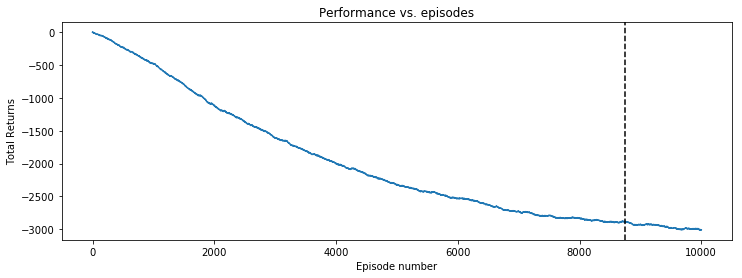

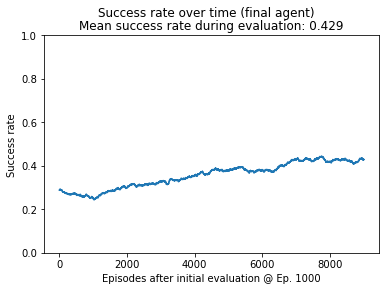

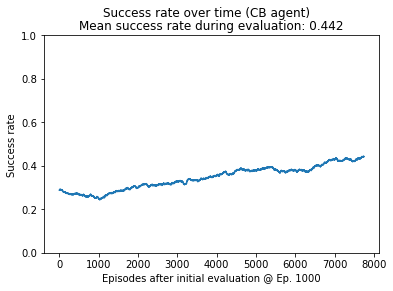

---------------------------
Validation metrics
---------------------------
After final episode, mean reward of -0.081 over last 1000 episodes --> succes rate: 0.429
After episode 8746, mean reward of -0.052 over last 1000 episodes --> succes rate: 0.442


In [116]:
# just one set of parameters to go through at this stage
grid_size = len(grid)
all_eval_metrics = train_agent(0, grid[0], False)

### 5) Optimization : training with grid search

Now that we know the Q-learning process is working, we can expand the grid search and simply-reuse our earlier functions to optimize learning. We will keep the grid fairly small so that this notebook does not get too large. (The first time I performed the grid search was with a much larger grid in Spyder, which I prefer for larger tasks.)

We will alo raise the number of episodes to train and evaluate over, so that we can get more robust estimations of performance.

At this point it is also useful to reduce verbosity to just validation metrics. We will split this into two chunks to reduce risk of any errors / crashes, with the first chunk using only the Boltzmann policy and the second only an e-greedy policy.

<div class="alert alert-block alert-danger" align="center"><b>Warning:</b> The next two blocks will take several hours to complete and may be difficult to interrupt! It took about 6 hours on my laptop. </div>

# started 18.36


In [133]:
# number of episodes to train agent over
NUM_EPISODES_TRAIN = 250000               

# evaluate agent with mean rewards over last (N) episodes
EVAL_LAST_N_EPS = 50000 

In [ ]:
# reduce verbosity level - feedback validation metrics only
VERBOSE = 0

# Create a grid of hyper parameters to search over
grid = ParameterGrid({"dbl_Q" : [0, 1],                 # 1 to use Double Q learning
                          "lr": [0.01, 0.1, 0.5],       # learning rate
                          "y": [0.3, 0.8],              # gamma
                          "policy": ["b"],              # "e" for e-greedy, "b" for boltzmann
                          "policy_param":  [1],         # tau (inverse temperature)
                          "num_episodes": [NUM_EPISODES_TRAIN],
                          "cb_over_num_eps": [EVAL_LAST_N_EPS],
                          "verbose": [VERBOSE]})
grid_size = len(grid)

# create a new array to store evaluation metrics for all agents
# we pass this to the function so that it can append a new row
# on each iteration
all_eval_metrics = []
for p_idx, params in enumerate(grid):
    all_eval_metrics = train_agent(p_idx, params, True, all_eval_metrics)

---------------------------
Now training agent 1/12
DblQ: 0.00 | LR: 0.010 | g: 0.300 | pol: b | pol_param: 1.00000
---------------------------
Validation metrics
---------------------------
After final episode, mean reward of -0.05378 over last 50000 episodes --> succes rate: 0.41958
After episode 182002, mean reward of -0.0475 over last 50000 episodes --> succes rate: 0.42506
---------------------------
Pickling agents
... complete
---------------------------
Now training agent 2/12
DblQ: 0.00 | LR: 0.010 | g: 0.800 | pol: b | pol_param: 1.00000


In [ ]:
# Create a grid of hyper parameters to search over
grid = ParameterGrid({"dbl_Q" : [0, 1],                 # 1 to use Double Q learning
                          "lr": [0.01, 0.1, 0.5],       # learning rate
                          "y": [0.3, 0.8],              # gamma
                          "policy": ["e"],              # "e" for e-greedy, "b" for boltzmann ## MODIFIED ##
                          "policy_param":  [0.6],       # epsilon ## MODIFIED ##
                          "num_episodes": [NUM_EPISODES_TRAIN],
                          "cb_over_num_eps": [EVAL_LAST_N_EPS],
                          "verbose": [VERBOSE]})
grid_size = len(grid)

# pass the same evaluation metric array
for p_idx, params in enumerate(grid):
    all_eval_metrics = train_agent(p_idx, params, True, all_eval_metrics)

We can now summarise the results for all our trained agents:

In [ ]:
# define column names and form a dataframe of results
# we order by the evaluation metric MeanR_lastN and show top 5
col_names = ['agent_filepath', 'DoubleQ', 'lr', 'y', 'policy', 'pol_param', 'num_episodes',
             'cb_over_num_episodes', 'cb_creation_idx', 'meanR_lastN', 'success_rate_lastN']
eval_df = pd.DataFrame(data=np.array(all_eval_metrics), columns=col_names) \
            .sort_values(by='meanR_lastN', ascending=True) \
            .reset_index().drop('index', 1)
eval_df.head(5)

### 6. Comparison against human strategy

Unsurprisingly, none of our agents discovered a way to make money out of Blackjack in the long-run. We know this since their average reward per game maxes out around -0.04. In other words, they will lose (or sometimes draw) about X% of the time. Of course, winning Y% of the time is much better than when our agents first started!

An interesting comparison we can make is whether this Y% success rate is better than that achieved by humans. This is a little difficult since our version of Blackjack is non-standard and excludes the "split" option, which can be helpful in hedging bets. <a href="https://www.blackjackapprenticeship.com/blackjack-strategy-charts/" target="_blank">BlackjackApprenticeship.com</a> offers advice for non-splitting scenarios, which appears to be a sensible set of instructions we can use in our version of the game.

We have encoded the advice into matrices held in csv format, visualised below:


<Figure size 432x288 with 0 Axes>

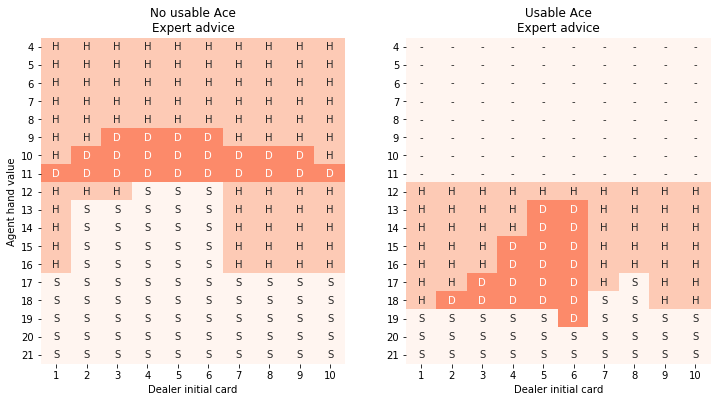

In [121]:
def action_dict(a, short=False):
    """ Return the initial letter or name of action given an action index"""
    if short:
        lookup = {0: "S", 1: "H", 2: "D", 3: "U", 4: "I"}
    else:
        lookup = {0: "Stick", 1: "Hit", 2: "Double", 3: "Surrender", 4: "Invest"}
    return lookup[a]

def make_adviceChart(Q_in, add_title='', smeChart=False):
    """ Find the argmax for each value of Q matrix along the action dimension
        Convert each to the name label of the action & color code 
        This acts as an easy 'advice chart' to support understanding """
    # take top-expectation action per state
    if not(smeChart):
        Qa_max = np.argmax(Q, axis=-1)
        
    # split into no usable ace / useable ace states
    plt.figure()
    f, axes = plt.subplots(1,2, sharex=False, sharey=False,
                                      figsize=(12,6))
    plt.title('Advised action chart per state')
    j_labels = ['No usable Ace', 'Usable Ace']
    for j in [0,1]:
        # load human advice charts rather than Q matrix if requested
        if ((smeChart) & (j==0)):
            Qa_max = np.array(pd.read_csv('additional_analysis/sme_advice_noUseableAce.csv'))
            Qa_maxJ = Qa_max[4:,:]
        elif ((smeChart) & (j==1)):
            Qa_max = np.array(pd.read_csv('additional_analysis/sme_advice_UseableAce.csv'))
            Qa_maxJ = Qa_max[4:,:]
        else:
            Qa_maxJ = Qa_max[4:22,1:,j]
            
        # convert action IDs to labels
        Qa_maxJ_label = np.chararray((Qa_maxJ.shape[0], Qa_maxJ.shape[1]), unicode=True)
        for x in np.arange(0, Qa_maxJ.shape[0]):
            for y in np.arange(0, Qa_maxJ.shape[1]):
                # for invalid values label as "-"
                if ((j==1) & (x<=7)):
                    Qa_maxJ_label[x,y] = "-"                                        
                else:
                    Qa_maxJ_label[x,y] = action_dict(Qa_maxJ[x,y], short=True)

        # obtain the relevant Q values - hiding non-used states (4- & 22+ for player / 0 for dealer)
        g = sns.heatmap(Qa_maxJ, cmap='Reds', annot=Qa_maxJ_label, fmt ='',
                        cbar=False, ax=axes[j], vmin=0, vmax=5)
        g.set_title("{}{}".format(j_labels[j], add_title))
        g.set_xlabel('Dealer initial card')
        # set agent hand value range of 4-21 inclusive, dealer 2-11 inclusive
        g.set_yticklabels(np.arange(4,22), rotation=0)
        g.set_xticklabels(np.arange(1,11), rotation=0)  # where Ace = 1 for now
        # only show y label on first plot
        if j == 0:
            g.set_ylabel('Agent hand value')

make_adviceChart(Q_in = None, add_title='\nExpert advice', smeChart=True)

Now that we have visualised the human strategy, we will form a 3D matrix aligned to the format of the Q-matrices our agents were using. Rather than storing estimated values, however, it will simply store the ID of the action to take for any given state. This will help us insert the static strategy into the environment with minimal code changes required.

In [ ]:
# load files and stack into a 3D array
Qh_no_ace = np.array(pd.read_csv('additional_analysis/sme_advice_noUseableAce.csv'))
Qh_ace = np.array(pd.read_csv('additional_analysis/sme_advice_UseableAce.csv'))
Qh = np.dstack([Qh_no_ace, Qh_ace])

Now we can perform 50,000 simulations and calculate the average reward and success rate for this human strategy. Since the strategy is fixed and no learning is occurring, we do not need to play the full 250,000 games that the agents played. We must however ensure the strategy is evaluated over the same number of simulations: 50,000.

To get a better estimate of these evaluation metrics, we will perform the 50,000 simulations 50 times and take the average.

In [ ]:
num_simulation_rounds = 50
list_meanR = []
list_success = []
for t in np.arange(0, num_simulation_rounds):
    #create list to contain total rewards and steps per episode
    rList = []

    print("Starting simulations")
    for i in range(EVAL_LAST_N_EPS):
        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0

        # game will not exceed 20 moves, limit while loop out of caution
        while j < 20:
            j+=1

            # choose action per fixed strategy
            # need to adjust the indices slightly for true alignment
            a = Qh[s[0], s[1]-1, s[2]]

            #Get new state and reward from environment
            player_hand_old = env.player.copy()
            s1,r,d,_ = env.step(a)

            # update rewards and state
            rAll += r
            s = s1

            # end game when a winner/loser found
            if d == True:            
                # For each of the final 5 episodes, show the game for inspection
                if ((i >= (EVAL_LAST_N_EPS-5)) & (t==0)):
                    show_ep(env.player, env.dealer, r, i)
                break

        # append reward to list
        rList.append(rAll)

    # show overall success history of fixed strategy for first simulation round
    if t == 0:
        plt.figure(figsize=(12,4))
        plt.plot(np.cumsum(rList))
        plt.title('Performance vs. episodes (Human strategy - first simulation round)')
        plt.ylabel('Total Returns')
        plt.xlabel('Episode number')
        plt.show()

    meanR = meanR_lastN(rList, EVAL_LAST_N_EPS)
    ts_success, mean_success_rate = calc_success_rate(rList, produce_ts=False)
    
    print("Mean rewards of %.5f over %i games --> success rate: %.5f" % (meanR,
                                                                          EVAL_LAST_N_EPS,
                                                                          mean_success_rate))
    # add new metrics to running lists
    list_meanR.append(meanR)
    list_success.append(mean_success_rate)

In [ ]:
# now show averages of evaluation metrics after all the simulations
print("--------------FINAL EVALUATION METRICS")
print("Mean of mean rewards: %.5f" % np.array(list_meanR).mean())
print("Mean of success rates: %.5f" % np.array(list_success).mean())

f, (ax1, ax2) = plt.subplots(1,2)
ax1.hist(np.array(list_meanR))
ax2.hist(np.array(list_success))
plt.show()